In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd

In [3]:
import os

In [5]:
x=os.listdir('/kaggle/input/hardfakevsrealfaces/fake')


In [4]:
fake_dir = "/kaggle/input/hardfakevsrealfaces/fake"

In [5]:
real_dir = "/kaggle/input/hardfakevsrealfaces/real"

In [7]:
import cv2
import os
data =[]
for filename in os.listdir(real_dir):
    filepath=os.path.join(real_dir,filename)
    img=cv2.imread(filepath)
    if img is not None :
        img=cv2.cvtColor(img ,cv2.COLOR_BGR2RGB )
        data.append((img,1))
        
for filename in os.listdir(fake_dir):
    filepath=os.path.join(fake_dir,filename)
    img=cv2.imread(filepath)
    if img is not None :
        img=cv2.cvtColor(img ,cv2.COLOR_BGR2RGB )
        data.append((img,0))

In [14]:
data[0][1]

1

1


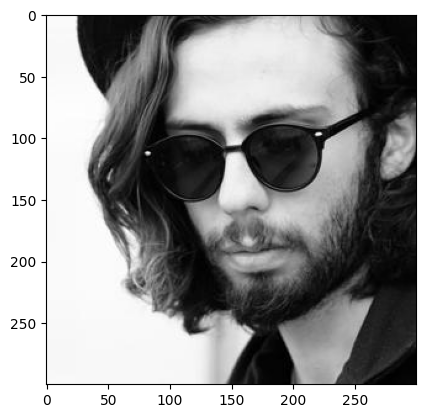

In [19]:
import matplotlib.pyplot as plt
plt.imshow(data[500][0])
print(data[500][1])


In [23]:
IMAGE_SIZE = 128  # Taille de redimensionnement (exemple : 128x128)

def read_and_preprocess(img_path):
    # Lecture de l'image en couleur
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    # Redimensionnement de l'image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    
    # Conversion en float32 pour normaliser
    img = np.array(img, dtype='float32')
    
    # Normalisation des pixels entre 0 et 1
    img /= 255.0
    return img

# Fonction pour charger et prétraiter toutes les images du dataset

In [ ]:
import cv2
import numpy as np  # Assurez-vous d'importer numpy
import os

# Définir la taille cible des images globalement
IMAGE_SIZE = 224

def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img, dtype='float32') / 255.0  # Utilisation de np pour convertir et normaliser l'image
    return img

def load_dataset(fake_dir, real_dir):
    images = []
    labels = []
    
    for filename in os.listdir(fake_dir):
        filepath = os.path.join(fake_dir, filename)
        if os.path.isfile(filepath):
            try:
                img = read_and_preprocess(filepath)
                images.append(img)
                labels.append(0)  # Label 0 pour fake
            except Exception as e:
                print(f"Erreur lors de la lecture de l'image {filepath}: {e}")

    for filename in os.listdir(real_dir):
        filepath = os.path.join(real_dir, filename)
        if os.path.isfile(filepath):
            try:
                img = read_and_preprocess(filepath)
                images.append(img)
                labels.append(1)  # Label 1 pour real
            except Exception as e:
                print(f"Erreur lors de la lecture de l'image {filepath}: {e}")
    
    images = np.array(images)  # Convertir la liste d'images en tableau NumPy
    labels = np.array(labels)  # Convertir la liste de labels en tableau NumPy
    return images, labels

# Chemins des dossiers

# Charger tout le dataset
images, labels = load_dataset(fake_dir, real_dir)

# Afficher des informations sur le dataset
print(f"Nombre total d'images : {len(images)}")
print(f"Dimensions des images : {images.shape}")  # Devrait être (N, 128, 128, 3)
print(f"Labels : {labels.shape}")


Nombre total d'images : 1289
Dimensions des images : (1289, 128, 128, 3)
Labels : (1289,)


array([0.5647059 , 0.58431375, 0.5803922 ], dtype=float32)

In [33]:
image_to_display = images[0]  # Accéder à la première image dans le tableau

# Redimensionner l'image pour l'affichage (facultatif)
image_to_display = (image_to_display * 255).astype(np.uint8)

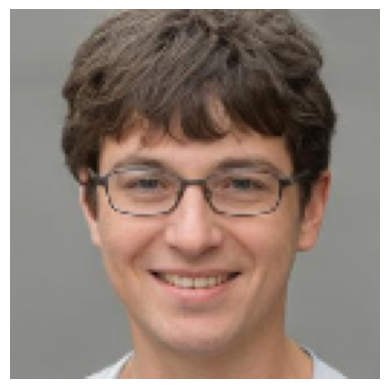

0


In [42]:
mage_to_display = images[0]

# Convertir l'image de BGR à RGB
image_to_display_rgb = cv2.cvtColor(image_to_display, cv2.COLOR_BGR2RGB)

# Utiliser matplotlib pour afficher l'image
plt.imshow(image_to_display_rgb)  # Afficher l'image après conversion
plt.axis('off')  # Enlever les axes
plt.show() 
print(labels[0])

split data

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


In [44]:
import tensorflow as tf


In [45]:
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.int32)

# Créer un Dataset TensorFlow pour l'entraînement et la validation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tf, y_train_tf))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tf, y_val_tf))

# Appliquer les transformations : mise en lot, mise en forme, et éventuelles augmentations
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [46]:
for images_batch, labels_batch in train_dataset.take(1):
    print(images_batch.shape)  # Doit afficher (batch_size, 128, 128, 3)
    print(labels_batch.shape)  

(32, 128, 128, 3)
(32,)


VGG-16

In [48]:
# Charger VGG16 pré-entraîné avec des poids ImageNet, sans les couches de classification
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Utiliser les poids pré-entraînés sur ImageNet
    include_top=False,   # Ne pas inclure la couche de classification supérieure
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)  # Taille de l'entrée adaptée à vos images
)


In [52]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Congeler les poids de VGG16 pour éviter de les modifier pendant l'entraînement
base_model.trainable = False

In [54]:
# Construire le modèle avec VGG16 comme base
model = tf.keras.Sequential([
    base_model,  # Ajouter le modèle VGG16 pré-entraîné
    tf.keras.layers.GlobalAveragePooling2D(),  # Pooling global
    tf.keras.layers.Dense(128, activation='relu'),  # Couche dense pour mieux apprendre
    tf.keras.layers.Dense(1, activation='sigmoid')  # Pour une classification binaire
])

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [55]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)


Epoch 1/50


I0000 00:00:1731609091.542825     325 service.cc:145] XLA service 0x7e6e1404c3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731609091.542877     325 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5319 - loss: 0.7491

I0000 00:00:1731609096.124960     325 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.6210 - loss: 0.6454 - val_accuracy: 0.8566 - val_loss: 0.4182
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9172 - loss: 0.3281 - val_accuracy: 0.9264 - val_loss: 0.2731
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9348 - loss: 0.2294 - val_accuracy: 0.9380 - val_loss: 0.1978
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9639 - loss: 0.1511 - val_accuracy: 0.9612 - val_loss: 0.1519
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9754 - loss: 0.1259 - val_accuracy: 0.9690 - val_loss: 0.1177
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9743 - loss: 0.1094 - val_accuracy: 0.9690 - val_loss: 0.1032
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9843 - loss: 0.0885 - val_accuracy: 0.9651 - val_loss: 0.1016
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9873 - loss: 0.0711 - val_accuracy: 0.9729 - val_loss: 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


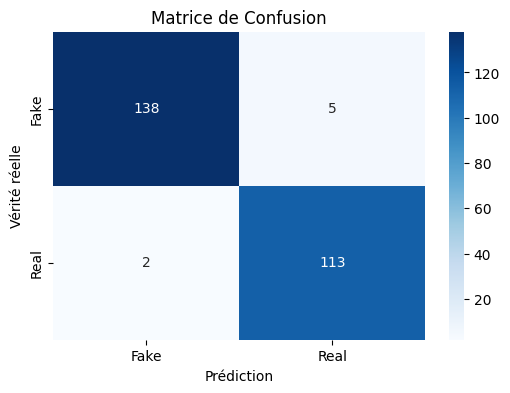

In [59]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_val)  # Prédictions sur l'ensemble de validation
y_pred = (y_pred > 0.5).astype(int)  # Convertir les sorties en labels binaires (0 ou 1)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_val, y_pred)

# Afficher la matrice de confusion avec Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vérité réelle')
plt.show()

In [62]:
import torch

torch.save(model, '/kaggle/working/full_model.pth')


In [63]:
model.save('model.h5')  # Remplacez 'model.h5' par le nom de votre modèle


In [65]:
import zipfile

# Sauvegardez votre modèle Keras dans un fichier .h5
model.save('/kaggle/working/model.h5')

# Créez un fichier ZIP contenant le modèle


In [66]:
from tensorflow.keras.models import load_model

# Charger le modèle à partir du fichier .h5
model = load_model("/kaggle/working/model.h5")

In [67]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,483 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)

In [70]:
import joblib
joblib.dump(model, "/kaggle/working/model.pkl")

['/kaggle/working/model.pkl']